<a href="https://colab.research.google.com/github/mehrabhosain/python/blob/main/Stenograpy_APDV_Color_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
pip install sewar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<ipython-input-4-5552a43bebbf>:97: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_cover_stego = ssim(cover_image, stego_image, multichannel=True)
<ipython-input-4-5552a43bebbf>:100: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_secret_extracted = ssim(secret_image_resized, extracted_secret_image, multichannel=True)


------------------------------------------------------------------------------------------------------------------
| Cover Image     | Secret Image    | PSNR       | SSIM (C vs S) | UIQ (C vs S) | SSIM (S vs ES) | UIQ (S vs ES) |
------------------------------------------------------------------------------------------------------------------
| /content/drive/MyDrive/Colab Notebooks/flower.jpg | /content/drive/MyDrive/Colab Notebooks/mehrab.jpg | 54.16      | 1.00       | 1.00       | 1.00       | 1.00       |
------------------------------------------------------------------------------------------------------------------
| /content/drive/MyDrive/Colab Notebooks/flower.jpg | /content/drive/MyDrive/Colab Notebooks/mahal.jpg | 54.14      | 1.00       | 1.00       | 1.00       | 1.00       |
------------------------------------------------------------------------------------------------------------------
| /content/drive/MyDrive/Colab Notebooks/flower.jpg | /content/drive/MyDrive/Colab N

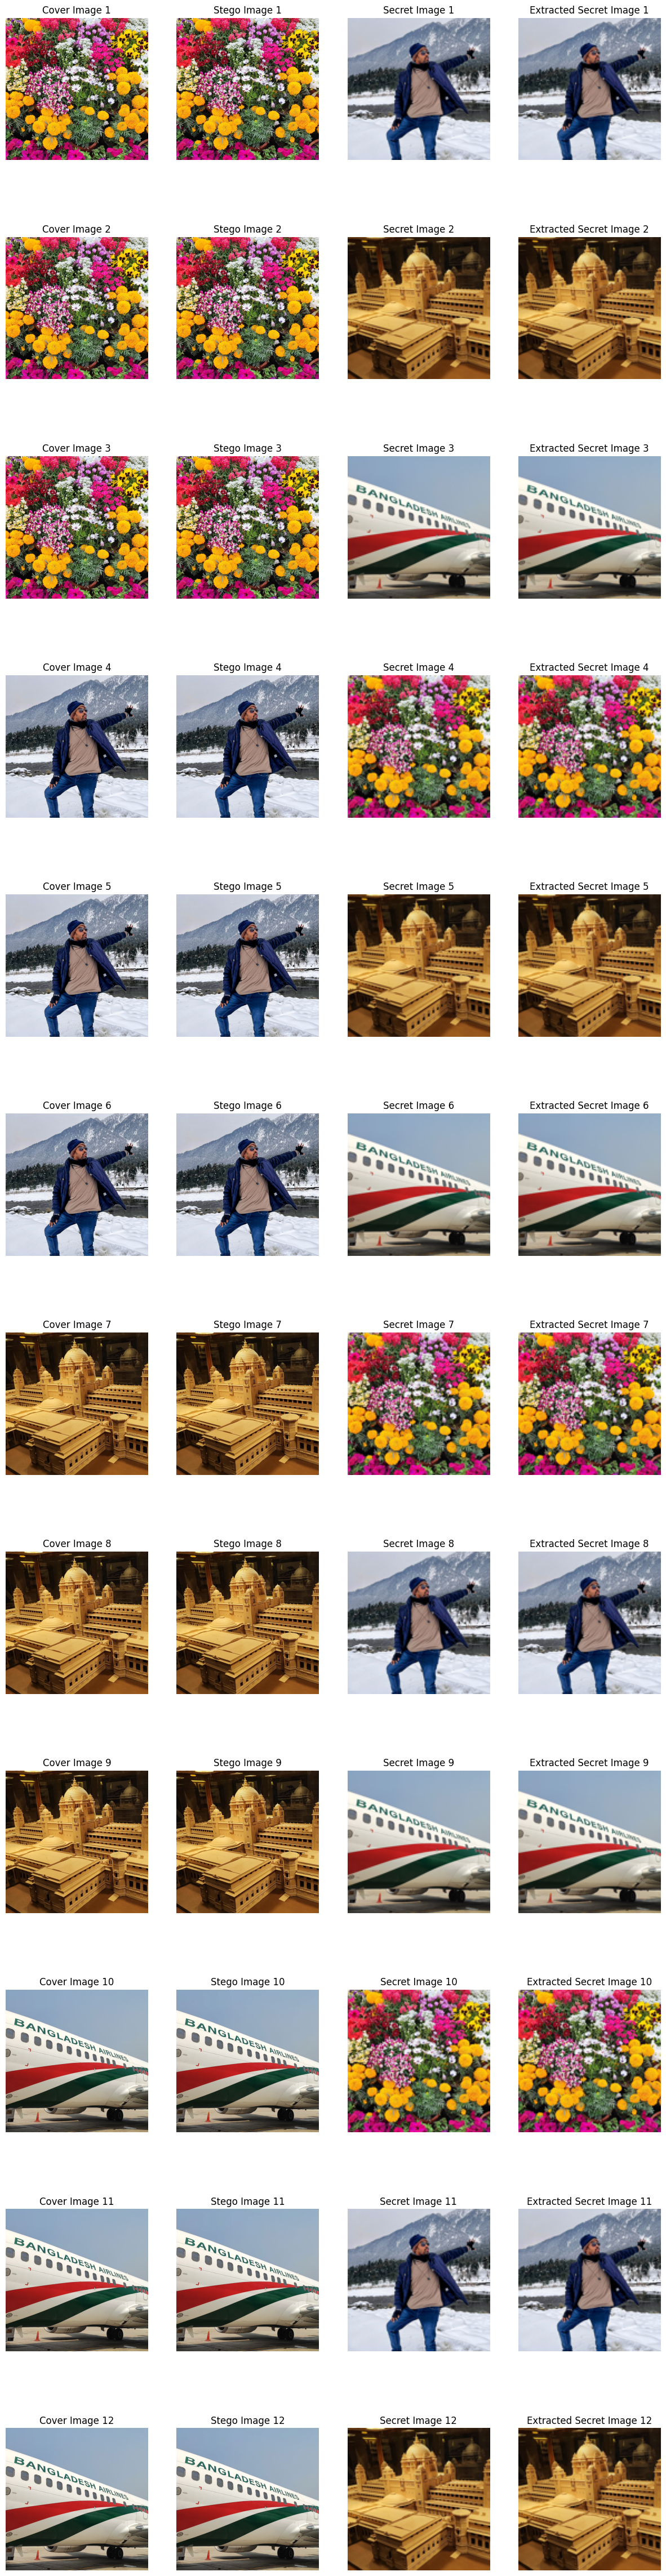

In [4]:
import numpy as np
import os
from PIL import Image
import tensorflow as tf
from skimage.filters import median
from skimage.metrics import peak_signal_noise_ratio, structural_similarity as ssim, mean_squared_error as mse
from sewar.full_ref import uqi as UniversalImageQualityIndex
import matplotlib.pyplot as plt
import time
import ipywidgets as widgets

# Include all the functions from previous responses, including:
# - APVD_embed
def APVD_embed_color(cover_image, secret_image):
    stego_image = np.copy(cover_image)

    for channel in range(cover_image.shape[2]):
        secret_image_bits = np.unpackbits(secret_image[:, :, channel])
        secret_image_bits = secret_image_bits.reshape(-1, 1)
        stego_channel = stego_image[:, :, channel]

        for i in range(min(len(secret_image_bits), len(stego_channel.flat) - 1)):
            if (stego_channel.flat[i] & 1) != secret_image_bits[i]:
                if stego_channel.flat[i] % 2 == 0:
                    stego_channel.flat[i] += 1
                else:
                    stego_channel.flat[i] -= 1

            if i + 1 < len(secret_image_bits) and stego_channel.flat[i] == stego_channel.flat[i + 1]:
                if stego_channel.flat[i + 1] % 2 == 0:
                    stego_channel.flat[i + 1] += 1
                else:
                    stego_channel.flat[i + 1] -= 1

    return stego_image

# APVD Extract
def APVD_extract_color(stego_image, secret_image_shape):
    extracted_secret_image = np.zeros(secret_image_shape, dtype=np.uint8)

    for channel in range(stego_image.shape[2]):
        secret_image_bits_length = secret_image_shape[0] * secret_image_shape[1] * 8
        extracted_bits = np.bitwise_and(stego_image[:, :, channel].flat[:secret_image_bits_length], 1)

        # Adjust the number of extracted bits to match the required bits for the secret image
        extracted_bits = extracted_bits[:secret_image_bits_length]

        # Handle cases where the number of extracted bits is less than the required bits
        if extracted_bits.size < secret_image_bits_length:
            extracted_bits = np.concatenate([extracted_bits, np.zeros(secret_image_bits_length - extracted_bits.size, dtype=int)])

        extracted_secret_channel = np.packbits(extracted_bits)
        extracted_secret_channel = extracted_secret_channel.reshape(secret_image_shape[:-1])
        extracted_secret_image[:, :, channel] = extracted_secret_channel

    return extracted_secret_image


# - display_images
def display_images(cover_image, secret_image, extracted_secret_image):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    ax1.imshow(cover_image)
    ax1.set_title('Cover Image')
    ax2.imshow(secret_image)
    ax2.set_title('Secret Image')
    ax3.imshow(extracted_secret_image)
    ax3.set_title('Extracted Secret Image')
    plt.show()

# - load_custom_images
def load_custom_images(filenames):
    images = []
    for filename in filenames:
        img = np.array(Image.open(filename))  # Read image as RGB
        img = np.array(Image.fromarray(img).resize((512, 512)))
        images.append(img)
    return images



# process_and_display_combinations function with the filenames
def process_and_display_combinations(images, filenames):
    results = []
    image_combinations = []
    resize_factor = 0.5  # Adjust this value to resize the secret image proportionally
    
    for i, cover_image in enumerate(images):
        for j, secret_image in enumerate(images):
            if i == j:
                continue

            secret_image_resized = np.array(Image.fromarray(secret_image).resize((128, 128)))
            stego_image = APVD_embed_color(cover_image, secret_image_resized)
            extracted_secret_image = APVD_extract_color(stego_image, secret_image_resized.shape)

            psnr_cover_stego = peak_signal_noise_ratio(cover_image, stego_image)
            ssim_cover_stego = ssim(cover_image, stego_image, multichannel=True)
            uiq_cover_stego = UniversalImageQualityIndex(cover_image, stego_image)

            ssim_secret_extracted = ssim(secret_image_resized, extracted_secret_image, multichannel=True)
            uiq_secret_extracted = UniversalImageQualityIndex(secret_image_resized, extracted_secret_image)

            result = {
                'cover_img_filename': filenames[i],
                'secret_img_filename': filenames[j],
                'psnr': psnr_cover_stego,
                'ssim_cover_stego': ssim_cover_stego,
                'uiq_cover_stego': uiq_cover_stego,
                'ssim_secret_extracted': ssim_secret_extracted,
                'uiq_secret_extracted': uiq_secret_extracted
            }
            results.append(result)
            image_combinations.append([cover_image, stego_image, secret_image_resized, extracted_secret_image])

    return results, image_combinations



# - display_results_table
def display_results_table(results):
    header = f"| {'Cover Image':<15} | {'Secret Image':<15} | {'PSNR':<10} | {'SSIM (C vs S)':<10} | {'UIQ (C vs S)':<10} | {'SSIM (S vs ES)':<10} | {'UIQ (S vs ES)':<10} |"
    separator = '-' * len(header)
    print(separator)
    print(header)
    print(separator)

    for result in results:
        row = f"| {result['cover_img_filename']:<15} | {result['secret_img_filename']:<15} | {result['psnr']:<10.2f} | {result['ssim_cover_stego']:<10.2f} | {result['uiq_cover_stego']:<10.2f} | {result['ssim_secret_extracted']:<10.2f} | {result['uiq_secret_extracted']:<10.2f} |"
        print(row)
        print(separator)

    return None

def display_extracted_images(image_combinations):
    rows = []
    for idx, (_, _, _, extracted_secret_image) in enumerate(image_combinations):
        row = [widgets.Image(value=Image.fromarray(extracted_secret_image.astype(np.uint8)).tobytes(), format='png', width=150, height=150)]
        rows.append(widgets.HBox(row))

    return widgets.VBox(rows)

#isplays only the extracted secret images:
def display_extracted_images(image_combinations):
    num_images = len(image_combinations)
    num_cols = 4
    num_rows = num_images // num_cols + int(num_images % num_cols > 0)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    
    if num_rows > 1:
        axes = axes.flatten()
    
    for idx, (_, _, _, extracted_secret_image) in enumerate(image_combinations):
        axes[idx].imshow(extracted_secret_image, cmap='gray')
        axes[idx].set_title(f"Extracted Secret Image {idx + 1}")
        axes[idx].axis("off")
    
    # Hide any remaining empty subplots
    for idx in range(len(image_combinations), num_rows * num_cols):
        axes[idx].axis("off")
    
    plt.show()


# display_image_table function
def display_image_table(image_combinations):
    num_images = len(image_combinations)
    num_cols = 4
    num_rows = 16
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

    if num_rows > 1:
        axes = axes.flatten()

    for idx, (cover_image, stego_image, secret_image, extracted_secret_image) in enumerate(image_combinations):
        for i, img in enumerate([cover_image, stego_image, secret_image, extracted_secret_image]):
            ax = axes[idx * num_cols + i]
            ax.imshow(img, cmap='gray')
            if i == 0:
                ax.set_title(f"Cover Image {idx + 1}")
            elif i == 1:
                ax.set_title(f"Stego Image {idx + 1}")
            elif i == 2:
                ax.set_title(f"Secret Image {idx + 1}")
            else:
                ax.set_title(f"Extracted Secret Image {idx + 1}")
            ax.axis("off")

    # Remove any extra subplots
    for i in range(num_images * num_cols, num_rows * num_cols):
        fig.delaxes(axes[i])

    plt.show()




# Main execution part
image_filenames = ["/content/drive/MyDrive/Colab Notebooks/flower.jpg", "/content/drive/MyDrive/Colab Notebooks/mehrab.jpg", "/content/drive/MyDrive/Colab Notebooks/mahal.jpg", "/content/drive/MyDrive/Colab Notebooks/biman.jpg"]
custom_images = load_custom_images(image_filenames)

# Process and display combinations
results, image_combinations = process_and_display_combinations(custom_images, image_filenames)

# Display results table
results_table = display_results_table(results)
print(results_table)

# Display image table
display_image_table(image_combinations)

